Les **SVM** à noyaux sont implémentées dans **scikit-learn** dans les classes **sklearn.svm.SVC** pour **la classification** et **sklearn.svm.SVR** pour **la régression** . Dans ces deux classes, vous pouvez spécifier un noyau grâce au paramètre **« kernel »**. Ce noyau peut être un des grands classiques **(linéaire, polynomial, RBF)**, mais vous pouvez aussi définir vos propres noyaux !

On utilise la classe **sklearn.svm.SVC en pratique** . Nous allons utiliser les données concernant **les caractéristiques physico-chimiques de vins blancs portugais** disponibles sur l'archive UCI. Il s'agit ici de prédire **le score (entre 3 et 9)** donné par des experts aux différents vins. Chargeons les données et transformons le problème en un problème de classification, pour lequel il s'agira de prédire si le score est supérieur à 6 **(vin de bonne qualité)** ou non 

In [1]:
import numpy as np

# charger les données
import pandas as pd
data = pd.read_csv('winequality-white.csv', sep=';')

# créer la matrice de données
X = data[data.columns[:-1]].values

# créer le vecteur d'étiquettes
y = data['quality'].values

# transformer en un problème de classification binaire
y_class = np.where(y<6, 0, 1)

Avant toute chose, nous allons découper nos données en **un jeu d'entraînement (X_train, y_train)** et **un jeu de test (X_test, y_test)**.

In [2]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_class, test_size=0.3)

Nous pouvons maintenant standardiser les variables, c'est-à-dire les centrer **(ramener leur moyenne à 0)** et les réduire **(ramener leur écart-type à 1)** , afin qu'elles se placent toutes à peu près sur la même échelle.

In [3]:
# standardiser les données
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)

X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

OK, nous pouvons enfin entraîner notre première **SVM à noyau** !

In [4]:
# Créer une SVM avec un noyau gaussien de paramètre gamma=0.01

from sklearn import svm
classifier = svm.SVC(kernel='rbf', gamma=0.01)

# Entraîner la SVM sur le jeu d'entraînement

classifier.fit(X_train_std, y_train)

SVC(gamma=0.01)

Comment se comporte-t-elle sur le jeu de test ? 

**Nous allons pour le comprendre regarder la courbe ROC** .

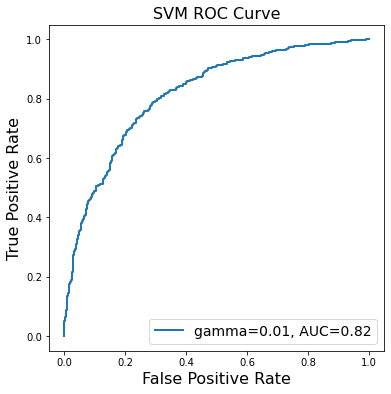

In [5]:
# prédire sur le jeu de test
y_test_pred = classifier.decision_function(X_test_std)

# construire la courbe ROC
from sklearn import metrics
fpr, tpr, thr = metrics.roc_curve(y_test, y_test_pred)

# calculer l'aire sous la courbe ROC
auc = metrics.auc(fpr, tpr)

# créer une figure
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(6, 6))

# afficher la courbe ROC
plt.plot(fpr, tpr, '-', lw=2, label='gamma=0.01, AUC=%.2f' % auc)

# donner un titre aux axes et au graphique
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)

# afficher la légende
plt.legend(loc="lower right", fontsize=14)

# afficher l'image
plt.show()

Nous allons ici utiliser une validation croisée sur le jeu d'entraînement pour sélectionner les valeurs optimales de C et de gamma parmi une grille de valeurs.

In [6]:
# choisir 6 valeurs pour C, entre 1e-2 et 1e3
C_range = np.logspace(-2, 3, 6)

# choisir 4 valeurs pour gamma, entre 1e-2 et 10
gamma_range = np.logspace(-2, 1, 4)

# grille de paramètres
param_grid = {'C': C_range, 'gamma': gamma_range}

# critère de sélection du meilleur modèle
score = 'roc_auc'

# initialiser une recherche sur grille
grid = model_selection.GridSearchCV(svm.SVC(kernel='rbf'), 
                                    param_grid, 
                                    cv=5, # 5 folds de validation croisée  
                                    scoring=score)

# faire tourner la recherche sur grille
grid.fit(X_train_std, y_train)

# afficher les paramètres optimaux
print( "The optimal parameters are {} with a score of {:.2f}".format(grid.best_params_, grid.best_score_) )

The optimal parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.86


Nous pouvons maintenant évaluer la performance de notre modèle optimisé sur le jeu de test :

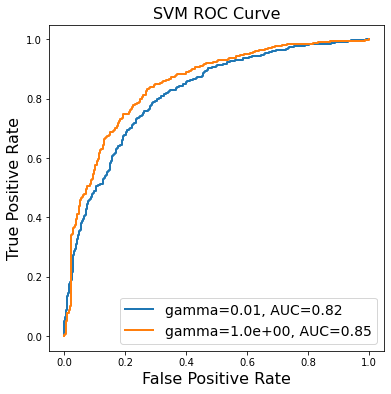

In [7]:
# prédire sur le jeu de test avec le modèle optimisé
y_test_pred_cv = grid.decision_function(X_test_std)

# construire la courbe ROC du modèle optimisé
fpr_cv, tpr_cv, thr_cv = metrics.roc_curve(y_test, y_test_pred_cv)

# calculer l'aire sous la courbe ROC du modèle optimisé
auc_cv = metrics.auc(fpr_cv, tpr_cv)

# créer une figure
fig = plt.figure(figsize=(6, 6))

# afficher la courbe ROC précédente
plt.plot(fpr, tpr, '-', lw=2, label='gamma=0.01, AUC=%.2f' % auc)

# afficher la courbe ROC du modèle optimisé
plt.plot(fpr_cv, tpr_cv, '-', lw=2, label='gamma=%.1e, AUC=%.2f' % \
         (grid.best_params_['gamma'], auc_cv))
         

# donner un titre aux axes et au graphique
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)

# afficher la légende
plt.legend(loc="lower right", fontsize=14)

# afficher l'image
plt.show()

Calculons la matrice de Gram obtenue sur notre jeu d'entraînement quand gamma=0.01 :

In [8]:
from sklearn import metrics
kmatrix = metrics.pairwise.rbf_kernel(X_train_std, gamma=0.01)

Nous allons réduire cette matrice à ses **100 premières lignes et 100 premières colonnes** pour en faciliter la visualisation :

In [11]:
kmatrix100 = kmatrix[:100, :100]

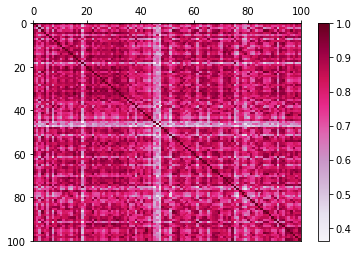

In [12]:
import matplotlib
# dessiner la matrice
plt.pcolor(kmatrix100, cmap=matplotlib.cm.PuRd) 

# rajouter la légende
plt.colorbar()

# retourner l'axe des ordonnées
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

# afficher l'image
plt.show()

Nous avons ici des valeurs de noyau comprises entre **0.40 et 1.0**, avec **une diagonale plus forte mais qui n'écrase pas la matrice.**